In [1]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate_question
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch.perceiver_io_best import PerceiverIObAbI, PonderLoss
import time
# from ranger21 import Ranger21
# from ranger import Ranger
# from warmup_scheduler import GradualWarmupScheduler
# from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# UT pondernet 1470003

model = PerceiverIObAbI(
    num_tokens = 179,
    context_max_seq_len = 783,
    question_max_seq_len = 13,
    depth = 10,
    dim = 128,
    input_queries_dim = 128,
    output_queries_dim = 128,
    latent_queries_dim = 128,
    num_output_queries = 2,
    num_latents = 64,
    logits_dim = 60,
    input_cross_heads = 4,
    cross_heads = 4,
    latent_heads = 8,
    input_cross_dim_head = 64,
    cross_dim_head = 64,
    latent_queries_dim_head = 64
)

model_name = 'perceiverIO_bAbi_sgd'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

2104314


In [8]:
from ranger21 import Ranger21
optimizer = Ranger21(model.parameters(), lr=1e-7, num_epochs=max_epochs, num_batches_per_epoch=len(babi_dataset)//batch_size+1, use_madgrad=True)

Ranger21 optimizer ready with following settings:

Core optimizer = madgrad
Learning rate of 1e-07

Important - num_epochs of training = ** 200 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 22608 of 31400
warm down will decay until 3e-05 lr


In [9]:
batch_size = 128
max_epochs = 400

# babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
#                            vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
# vocab_size = len(babi_dataset.QA.VOCAB)

print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)
# model.half()

# criterion = nn.CrossEntropyLoss(reduction='sum')
depth = 20
# criterion = PonderLoss(nn.CrossEntropyLoss(reduction='none'), 1/5, depth, 0.01).to(device) # .half()
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
# optimizer = Ranger21(model.parameters(), lr=3e-5, num_epochs=max_epochs, num_batches_per_epoch=len(babi_dataset)//batch_size+1, use_madgrad=True)
# optimizer = Ranger(model.parameters(), lr=3e-5)
# scheduler = ReduceLROnPlateau(optimizer, 'min')
# scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler)

# val_loss_min = float('inf')
# plateau = 0
# scaler = torch.cuda.amp.GradScaler()

# writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
# now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")
# sgd_loss_thresh = 0
for epoch in range(epoch, max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_question
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)#.half()
        questions = questions.long().to(device)#.half()
        answers = answers.to(device)#.half()
        
#         with torch.cuda.amp.autocast():
        p, y_hat, p_sampled, y_hat_sampled = model(contexts, questions)
        loss = criterion(p, y_hat, answers)
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        bs = int(answers.shape[0])
        if loss.item() / bs > sgd_loss_thresh:
            loss.backward()
            optimizer.step()
            loss_count+=1
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
                
    train_loss = train_loss / len(train_loader.dataset)
    sgd_loss_thresh = train_loss
    print(f'{loss_count}/{len(train_loader)}')
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_question
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            p, y_hat, p_sampled, y_hat_sampled = model(contexts, questions)
            loss = criterion(p, y_hat, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
#     scheduler.step(epoch, val_loss)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
#         plateau = 0
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss
#     else:
#         plateau += 1
#         if plateau > 5:
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = param_group['lr'] / 5

len(babi_dataset) train 20000
vocab_size 178
cuda:0


Epoch 200/400:   0%|          | 0/1407 [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 79
795/1407
Epoch: 200 	Training Loss: 0.693140 	Validation Loss: 0.700465
Validation loss decreased (0.747801 --> 0.700465).  Saving model ...


Epoch 201/400:   0%|          | 0/1407 [00:00<?, ?it/s]

767/1407
Epoch: 201 	Training Loss: 0.701599 	Validation Loss: 0.708248


Epoch 202/400:   0%|          | 0/1407 [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 1e-07

734/1407
Epoch: 202 	Training Loss: 0.709011 	Validation Loss: 0.722848


Epoch 203/400:   0%|          | 0/1407 [00:00<?, ?it/s]

720/1407
Epoch: 203 	Training Loss: 0.712502 	Validation Loss: 0.727993


Epoch 204/400:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/pyth

0.65305
                     precision    recall  f1-score   support

              apple       0.83      0.77      0.80       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.64      0.63      0.64      1195
            bedroom       0.65      0.62      0.64      1437
               bill       0.59      0.58      0.58       164
              bored       1.00      1.00      1.00       159
                cat       0.56      0.60      0.58       213
             cinema       0.41      0.50      0.45       171
                e,e       0.16      0.17      0.16        81
                e,n       0.00      0.00      0.00        88
                e,s       0.14      0.04      0.06        79
           football       0.74      0.80      0.77       281
     football,apple       0.00      0.00      0.00        18
football,apple,

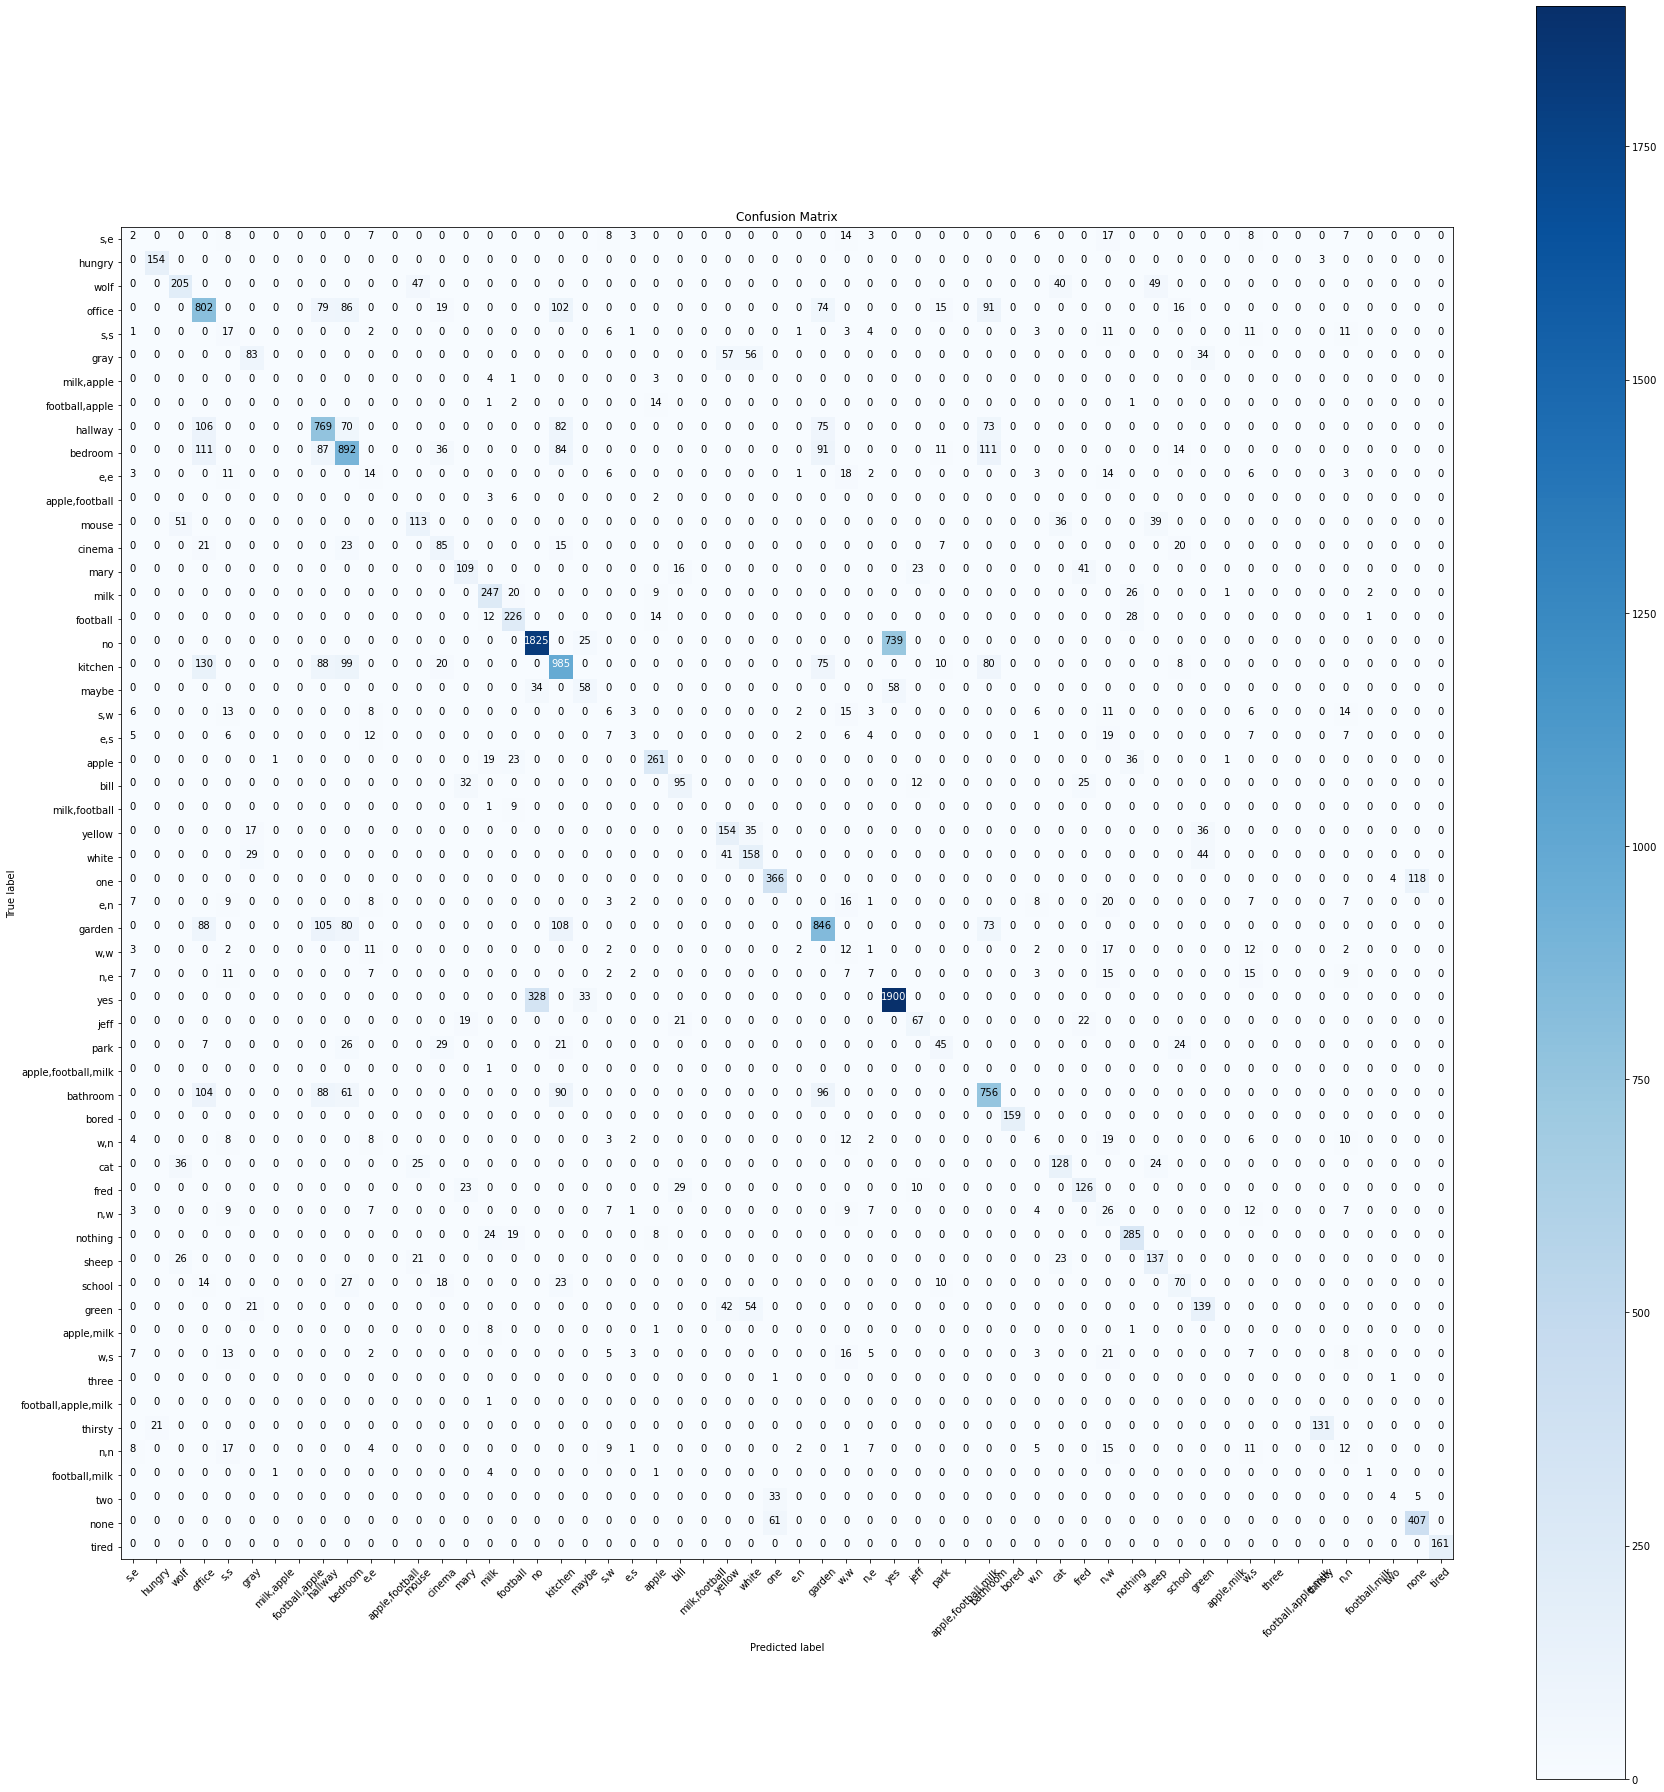

7.449124813079834


In [10]:
batch_size=128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
# now='29_08_2021__23_49_17'
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_question
)
output_vocab = eval('{0: 2, 1: 6, 2: 9, 3: 15, 4: 16, 5: 19, 6: 20, 7: 22, 8: 25, 9: 154, 10: 155, 11: 156, 12: 29, 13: 157, 14: 158, 15: 160, 16: 161, 17: 162, 18: 159, 19: 164, 20: 163, 21: 165, 22: 167, 23: 43, 24: 45, 25: 173, 26: 175, 27: 177, 28: 49, 29: 54, 30: 55, 31: 60, 32: 61, 33: 62, 34: 63, 35: 64, 36: 65, 37: 66, 38: 67, 39: 68, 40: 69, 41: 70, 42: 71, 43: 72, 44: 73, 45: 74, 46: 75, 47: 76, 48: 80, 49: 82, 50: 83, 51: 84, 52: 106, 53: 108, 54: 112, 55: 113, 56: 117, 57: 120, 58: 126, 59: 127}')
y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        p, y_hat, p_sampled, y_hat_sampled = model(contexts, questions)
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(y_hat_sampled.cpu())
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[output_vocab[int(i)]] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[output_vocab[int(i)]] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')p.shape

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [ ]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [ ]:
# model.layers.append(model.layers[1])
# print(len(model.layers))

In [ ]:
# batch_size=128
# babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
#                            vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
# vocab_size = len(babi_dataset.QA.VOCAB)
# babi_dataset.set_mode('valid')
# train_loader = DataLoader(
#     babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
# )
# max_context = 0
# for batch_idx, data in enumerate(tqdm(train_loader)):  
#     contexts, answers, tasks = data
# #     print(contexts.shape, answers.shape)
#     for b in range(contexts.shape[0]):
# #         print(f'Task {int(tasks[b])}:')
#         for i, w in enumerate(contexts[b]):
#             if w != 0:
#                 if i + 1 == contexts.shape[1]:
#                     max_context = i
#                     if i > 600:
#                         print(f'Task {int(tasks[b])}:')
#                         for i, w in enumerate(contexts[b]):
#                             if w != 0:
#                                 print(babi_dataset.QA.IVOCAB[int(w)], end=" ")
#                             else:
#                                 print(f'({i} words)')
#                                 break
# #                 print(babi_dataset.QA.IVOCAB[int(w)], end=" ")
                
#             else:
# #                 print(f'({i} words)')
#                 if i > max_context:
#                     max_context = i
#                     if i > 600:
#                         print(f'Task {int(tasks[b])}:')
#                         for i, w in enumerate(contexts[b]):
#                             if w != 0:
#                                 print(babi_dataset.QA.IVOCAB[int(w)], end=" ")
#                             else:
#                                 print(f'({i} words)')
#                                 break
#                 break
# #         print('\n')
# #         print(babi_dataset.QA.IVOCAB[int(answers[b])])
# #         print('\n')
# #     break
# print(max_context)

# batch_size=128
# babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
#                            vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
# vocab_size = len(babi_dataset.QA.VOCAB)
# babi_dataset.set_mode('train')
# train_loader = DataLoader(
#     babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_question
# )
# answer_list = []
# max_question = 0
# for batch_idx, data in enumerate(tqdm(train_loader)):  
#     contexts, questions, answers, tasks = data
#     answer_list += answers.tolist()
#     for b in range(questions.shape[0]):
#         for i, w in enumerate(questions[b]):
#             if w == 0:
#                 if i > max_question or i + 1 == questions.shape[1]:
#                     max_question = i

# babi_dataset.set_mode('test')
# for batch_idx, data in enumerate(tqdm(train_loader)):  
#     contexts, questions, answers, tasks = data
#     answer_list += answers.tolist()
#     for b in range(questions.shape[0]):
#         for i, w in enumerate(questions[b]):
#             if w == 0:
#                 if i > max_question or i + 1 == questions.shape[1]:
#                     max_question = i
                    
# babi_dataset.set_mode('valid')
# for batch_idx, data in enumerate(tqdm(train_loader)):  
#     contexts, questions, answers, tasks = data
#     answer_list += answers.tolist()
#     for b in range(questions.shape[0]):
#         for i, w in enumerate(questions[b]):
#             if w == 0:
#                 if i > max_question or i + 1 == questions.shape[1]:
#                     max_question = i
    
# print(len(set(answer_list)), set(answer_list))
# print(max_question)
# output_vocab = dict()
# for i, w in enumerate(set(answer_list)):
#     output_vocab[i] = w
# print(output_vocab)